In [86]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import folium
import streamlit as st
from streamlit_option_menu import option_menu
from streamlit_folium import folium_static

In [87]:
def importar(url):
    respuesta = requests.get(url)
    objeto = respuesta.json()
    return objeto

In [88]:
datos = pd.read_csv(r"C:\Users\juli_\Desktop\datos.csv")

In [89]:
'''url = "https://healthdata.gov/resource/g62h-syeh.json"
datos = pd.DataFrame(importar(url))'''

'url = "https://healthdata.gov/resource/g62h-syeh.json"\ndatos = pd.DataFrame(importar(url))'

In [90]:
datos["index"] = datos.index
datosB = datos[["index", "state","date"]]
del datos["date"]
del datos["state"]
datos = datos.apply(pd.to_numeric)
datos = datosB.merge(datos, on = "index", how="left")
datos["date"] = pd.to_datetime(datos['date'], format="%Y/%m/%d")
mask = (datos['date'] >= '2020-01-01') & (datos['date'] <= '2022-08-01')
datos=datos.loc[mask]
datos = datos.fillna(0)
del datos["index"]
datosestados = datos.groupby("state", as_index=False).sum()
datosestados["ocupacion"] = round((datosestados["inpatient_beds_used_covid"]/datosestados["inpatient_beds_used"])*100,2)
datosestados = datosestados.sort_values("ocupacion", ascending=False)
datos["Total UCI"] = datos["staffed_icu_adult_patients_confirmed_and_suspected_covid"]+datos["staffed_icu_pediatric_patients_confirmed_covid"]
datos["total"] = datos["staffed_adult_icu_bed_occupancy"] + datos["staffed_pediatric_icu_bed_occupancy"]
datosB = datos[["state", "total","staffed_adult_icu_bed_occupancy","staffed_pediatric_icu_bed_occupancy" ]]
datosB= datosB.groupby("state", as_index=False).sum().sort_values("total", ascending=False)
datosB.rename(columns={"state":"estado", "staffed_adult_icu_bed_occupancy": "Ocupacion Adultos", "staffed_pediatric_icu_bed_occupancy": "Ocupacion pediatrico"}, inplace=True)
datosB.reset_index(inplace=True)
datosB=round(datosB,1)
cantcamasco19 = datosestados[["state", "inpatient_beds_used_covid"]]
cantcamasco19.rename(columns={"state":"estado", "inpatient_beds_used_covid":"Camas utilizadas"}, inplace=True)
cantcamasco19.reset_index(inplace=True)

C:\Users\juli_\AppData\Local\Temp\ipykernel_15040\2708787481.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  datos["Total UCI"] = datos["staffed_icu_adult_patients_confirmed_and_suspected_covid"]+datos["staffed_icu_pediatric_patients_confirmed_covid"]
C:\Users\juli_\AppData\Local\Temp\ipykernel_15040\2708787481.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  datos["total"] = datos["staffed_adult_icu_bed_occupancy"] + datos["staffed_pediatric_icu_bed_occupancy"]
C:\Users\juli_\AppData\Local\Temp\ipykernel_15040\27087874

1 - ¿Cuáles fueron los 5 Estados con mayor ocupación hospitalaria por COVID? Criterio de ocupación por cama común. Considere la cantidad de camas ocupadas con pacientes confirmados y tome como referencia los 6 primeros meses del 2020 - recuerde incluir la cifra de infectados en esos meses (acumulativo). ¿Influye el rango etario en este comportamiento?

In [91]:
mask = (datos['date'] >= '2020-01-01') & (datos['date'] <= '2020-06-30')
datos_1 = datos[mask]
datos_1.sort_values("date", ascending=False)
datos_01 = datos_1.groupby("state", as_index=False).sum()
datos_01["ocupacion"] = round((datos_01["inpatient_beds_used_covid"]/datos_01["inpatient_beds_used"])*100,2)
datos_01 = datos_01.sort_values("ocupacion", ascending=False).head(5)
datos_01 = datos_01[["state","ocupacion"]]
datos_01.rename(columns={"state":"estado"}, inplace=True)
datos_01.reset_index(inplace=True)

C:\Users\juli_\AppData\Local\Temp\ipykernel_15040\1131958448.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  datos_01 = datos_1.groupby("state", as_index=False).sum()


2 - Analice la ocupación de camas (Común) por COVID en el Estado de Nueva York durante la cuarentena establecida e indique:

Intervalos de crecimiento y decrecimiento
Puntos críticos (mínimos y máximos)

22 de Marzo 2020 - 13 de Junio de 2020

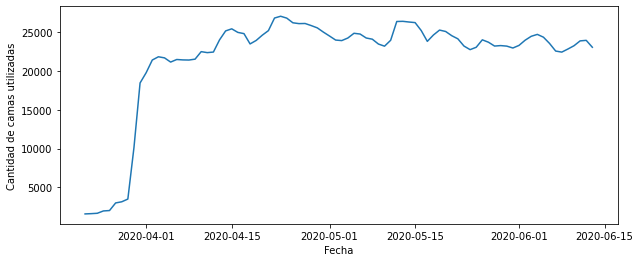

In [92]:
datos_2 = datos[["state","date", "inpatient_beds_used"]]
mask = (datos_2['date'] >= '2020-03-22') & (datos_2['date'] <= '2020-06-13') & (datos_2["state"]=="NY")
datos_2 = datos_2[mask]
datos_2.rename(columns={"date":"Fecha", "inpatient_beds_used": "Cantidad de camas utilizadas"}, inplace=True)
datos_2.reset_index(inplace=True)
grafico_p2 = plt.figure(figsize=(10, 4))
sns.lineplot(x=datos_2["Fecha"], y=datos_2["Cantidad de camas utilizadas"])
datos_02 = datos_2.sort_values("Cantidad de camas utilizadas", ascending=False)
datos_02.reset_index(inplace=True)


3 - ¿Cuáles fueron los cinco Estados que más camas UCI -Unidades de Cuidados Intensivos- utilizaron durante el año 2020? La medición debe realizarse en términos absolutos.

In [93]:

datos_3 = datos[["date", "state","staffed_adult_icu_bed_occupancy", "staffed_pediatric_icu_bed_occupancy"]]
mask = (datos_3['date'] >= '2020-01-01') & (datos_3['date'] <= '2020-12-31')
datos_3 = datos_3[mask]
datos_3["Total"] = datos_3["staffed_adult_icu_bed_occupancy"] + datos_3["staffed_pediatric_icu_bed_occupancy"]
datos_03 = datos_3.groupby("state", as_index=False).sum().sort_values("Total",ascending=False).head(5)
datos_03.reset_index(inplace=True)
datos_03.rename(columns={'state': 'Estado', 'staffed_adult_icu_bed_occupancy': 'Adultos', 'staffed_pediatric_icu_bed_occupancy': 'Pediatrico'}, inplace=True)


4 - ¿Qué cantidad de camas se utilizaron, por Estado, para pacientes pediátricos con COVID durante el 2020?

In [94]:

datos_4 = datos[["date", "state","all_pediatric_inpatient_bed_occupied",]]
mask = (datos_4['date'] >= '2020-01-01') & (datos_4['date'] <= '2020-12-31')
datos_4 = datos_4.loc[mask]
datos_04 = datos_4.groupby("state", as_index=False).sum().sort_values("all_pediatric_inpatient_bed_occupied",ascending=False)
datos_04.reset_index(inplace=True)
datos_04.rename(columns={'state': 'Estado', 'all_pediatric_inpatient_bed_occupied': 'Ocupacion camas pediatricas'}, inplace=True)

5 - ¿Qué porcentaje de camas UCI corresponden a casos confirmados de COVID-19? Agrupe por Estado.
Adultos + pediatricos

In [95]:
datos_5 = datos[["date", "state","total_staffed_pediatric_icu_beds","total_staffed_adult_icu_beds", "staffed_icu_adult_patients_confirmed_and_suspected_covid" , "staffed_icu_pediatric_patients_confirmed_covid"]]
datos_5["total_icu"] = datos_5["total_staffed_pediatric_icu_beds"] + datos_5["total_staffed_adult_icu_beds"]
datos_5["total_icu_covid"] = datos_5["staffed_icu_pediatric_patients_confirmed_covid"]+datos_5["staffed_icu_adult_patients_confirmed_and_suspected_covid"]
datos_5 = datos_5.groupby("state").sum()
datos_5["% Uso Covid"] = round((datos_5["total_icu_covid"]/datos_5["total_icu"])*100,2)
datos_05 = datos_5["% Uso Covid"].sort_values(ascending=False)

C:\Users\juli_\AppData\Local\Temp\ipykernel_15040\2405303367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_5["total_icu"] = datos_5["total_staffed_pediatric_icu_beds"] + datos_5["total_staffed_adult_icu_beds"]
C:\Users\juli_\AppData\Local\Temp\ipykernel_15040\2405303367.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_5["total_icu_covid"] = datos_5["staffed_icu_pediatric_patients_confirmed_covid"]+datos_5["staffed_icu_adult_patients_confirmed_and_suspected_covid"]


6 - ¿Cuántas muertes por covid hubo, por Estado, durante el año 2021?

In [96]:
datos_6 = datos[["date","state", "deaths_covid"]]
mask = (datos_6['date'] >= '2021-01-01') & (datos_6['date'] <= '2021-12-31')
datos_6 = datos_6.loc[mask]
datos_06 = datos_6.groupby("state", as_index=False).sum().sort_values("deaths_covid", ascending=False)
datos_06.reset_index(inplace=True)
datos_06.rename(columns={'state': 'Estado', 'deaths_covid': 'Muertes por covid'}, inplace=True)

7 - ¿Qué relación presenta la falta de personal médico, con la cantidad de muertes por covid durante el año 2021?




In [97]:
mask = (datos['date'] >= '2021-01-01') & (datos['date'] <= '2021-12-31')
datos_7 = datos[mask]
datos_7.dropna(inplace=True)
relacion_07 = round(datos_7['deaths_covid'].corr(datos_7['critical_staffing_shortage_today_yes']),2)
datos_07=datos_7.corr()['deaths_covid'].sort_values(ascending=False)

C:\Users\juli_\AppData\Local\Temp\ipykernel_15040\2758063813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_7.dropna(inplace=True)


8 - Siguiendo las respuestas anteriores, ¿cuál fue el peor mes de la pandemia para USA en su conjunto? Puede utilizar otras medidas que considere necesarias.

In [98]:
datos_8 = datos[["date", "deaths_covid", "critical_staffing_shortage_today_yes", "inpatient_beds_used_covid",  "total_adult_patients_hospitalized_confirmed_and_suspected_covid", "total_patients_hospitalized_confirmed_influenza_and_covid"]]
datos_8 = datos_8.fillna(0)
datos_8["monthofyear"] = pd.DatetimeIndex(datos_8['date']).month + (pd.DatetimeIndex(datos_8['date']).year)*100
datos_08 = datos_8.groupby("monthofyear", as_index=False).sum().sort_values("deaths_covid", ascending=False)
datos_08.reset_index(inplace=True)
datos_08.rename(columns={'monthofyear': 'Ano/Mes', 'deaths_covid': 'Muertes por covid', "critical_staffing_shortage_today_yes": "Falta de personal","inpatient_beds_used_covid":"Camas covid","total_adult_patients_hospitalized_confirmed_and_suspected_covid":"Adultos COVID +", "total_patients_hospitalized_confirmed_influenza_and_covid": "Pacientes COVID + Influenza" }, inplace=True)

9 - ¿Qué recomendaciones haría, ex post, con respecto a los recursos hospitalarios y su uso?



<AxesSubplot:>

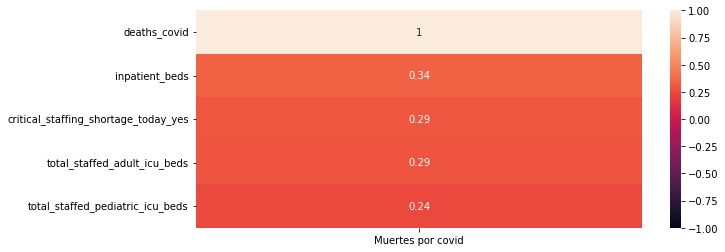

In [99]:
datos_9 = datos[['state', 'date', 'critical_staffing_shortage_today_yes', "inpatient_beds", "total_staffed_pediatric_icu_beds", "total_staffed_adult_icu_beds", "deaths_covid", ]]
datoscorr = datos_9.corr()
datoscorr.rename(columns={'deaths_covid': 'Muertes por covid', "critical_staffing_shortage_today_yes": "Falta de personal","inpatient_beds":"Total camas","total_staffed_pediatric_icu_beds": "UCI Pediatricas", "total_staffed_adult_icu_beds": "UCI Adultos" }, inplace=True)
heatdatoscorr = plt.figure(figsize=(10, 4))
sns.heatmap(datoscorr[['Muertes por covid']].sort_values(by='Muertes por covid', ascending=False), vmin=-1, vmax=1, annot=True)

Graficos

In [100]:
url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
state_geo = f"{url}/us-states.json"
mapaMuertes = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=state_geo,
    data=datos_06,
    columns=["Estado", "Muertes por covid"],
    key_on="feature.id",
    fill_color="OrRd",
    fill_opacity=1,
    line_opacity=0.5,
    legend_name="Cantidad de muertes",
).add_to(mapaMuertes)
folium.LayerControl().add_to(mapaMuertes)

In [101]:

mapaHospitalizados = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=state_geo,
    data=datos,
    columns=["state", "inpatient_beds_used_covid"],
    key_on="feature.id",
    fill_color="Greens",
    fill_opacity=1,
    line_opacity=0.5,
    legend_name="Cantidad de hospitalizados",
).add_to(mapaHospitalizados)
folium.LayerControl().add_to(mapaHospitalizados)

In [102]:
mapacamasUCI = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=state_geo,
    data=datos,
    columns=["state", "Total UCI"],
    key_on="feature.id",
    fill_color="BuPu",
    fill_opacity=1,
    line_opacity=0.5,
    legend_name="Uso de camas UCI",
).add_to(mapacamasUCI)
folium.LayerControl().add_to(mapacamasUCI)

In [103]:
mapaocuphospit = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=state_geo,
    data=datosestados,
    columns=["state", "ocupacion"],
    key_on="feature.id",
    fill_color="BuPu",
    fill_opacity=1,
    line_opacity=0.5,
    legend_name="Ocupacion hospitalaria",
).add_to(mapaocuphospit)
folium.LayerControl().add_to(mapaocuphospit)

Streamlit

In [104]:
st.set_page_config(layout="wide")
with st.sidebar:
    choose = option_menu("App Gallery", ["Portada", "Introduccion","Cantidad de hospitalizados", "Uso de camas UCI", "Ocupación hospitalaria","Cantidad de camas ocupadas por Covid-19", "Los 5 Estados con mayor ocupación hospitalaria por COVID", "Ocupacion de camas por pacientes COVID19 - Nueva York","Los 5 Estados con mayor utilizacion de camas UCI", "Cantidad de camas utilizadas para pacientes pediátricos con COVID", "Porcentaje de camas UCI correspondientes a casos confirmados de COVID-19", "Cantidad de muertes por COVID-19", "Relacion entre muertes y falta de personal", "Peores meses de la pandemia en USA", "Conclusiones", "Preguntas"])

2022-08-11 10:36:41.260 
  command:

    streamlit run c:\Users\juli_\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [105]:
if choose == "Portada":
    st.title("Proyecto Individual #2")
    st.image("https://camo.githubusercontent.com/35b81f213ddb0e019b3567f6982d740bb2d01ae5dd712a1537e09e826e940228/68747470733a2f2f643331757a386c77666d796e38672e636c6f756466726f6e742e6e65742f4173736574732f6c6f676f2d68656e72792d77686974652d6c672e706e67")
    st.header("Julián Mediavilla")
    st.subheader("Argentina,2022")

In [106]:
elif choose == "Introduccion":
    st.title("EE.UU. Covid-19")
    st.header("01/01/2020 - 01/08/2022")
    st.image("https://www.etapainfantil.com/wp-content/uploads/2021/05/Mapa-politico-Estados-Unidos.jpg")

SyntaxError: invalid syntax (3747823721.py, line 1)

In [ ]:
elif choose == "Cantidad de hospitalizados":
    st.title("Cantidad de hospitalizados")
    folium_static(mapaHospitalizados)

In [ ]:
elif choose == "Uso de camas UCI":
    st.title("Uso de camas UCI")
    st.write(datosB))

In [ ]:
elif choose == "Ocupación hospitalaria":
    st.title("Ocupación hospitalaria")
    folium_static(mapaocuphospit)

In [ ]:
elif choose == "Cantidad de camas ocupadas por Covid-19":
    st.title("Cantidad de camas ocupadas por Covid-19")
    st.write(cantcamasco19)

In [ ]:
elif choose == "Los 5 Estados con mayor ocupación hospitalaria por COVID":
    #Preg1
    st.title("Los 5 Estados con mayor ocupación hospitalaria por COVID")
    st.header("Primer semestre del 2020")
    st.write(datos_01)

In [ ]:
elif choose == "Ocupacion de camas por pacientes COVID19 - Nueva York":
    #Preg2
    st.title("Ocupacion de camas por pacientes COVID19 - Nueva York")
    st.header("22/03/2020 - 13/06/2020")
    st.write(grafico_p2)
    st.write(datos_02)

In [ ]:
elif choose == "Los 5 Estados con mayor utilizacion de camas UCI":
    #Preg3
    st.title("Los 5 Estados con mayor utilizacion de camas UCI")
    st.header("Año 2020")
    st.write(datos_03)

In [ ]:
elif choose == "Cantidad de camas utilizadas para pacientes pediátricos con COVID":
    #Preg4
    st.title("Cantidad de camas utilizadas para pacientes pediátricos con COVID")
    st.header("Año 2020")
    st.write(datos_04)

In [ ]:
elif choose == "Porcentaje de camas UCI correspondientes a casos confirmados de COVID-19":
    #Preg5
    st.title("Porcentaje de camas UCI correspondientes a casos confirmados de COVID-19")
    st.write(datos_05)

In [ ]:
elif choose == "Cantidad de muertes por COVID-19":
    #Preg6
    st.title("Cantidad de muertes por COVID-19")
    folium_static(mapaMuertes)
    st.write(datos_06)

In [ ]:
elif choose == "Relacion entre falta de personal y muertes":
    #Preg7
    st.title("Relacion entre falta de personal y muertes")
    st.write(datos_07.head(10))
    st.subheader("Relacion:")
    st.write(relacion_07)

In [ ]:
elif choose == "Peores meses de la pandemia en USA":
    #Preg8
    st.title("Peores meses de la pandemia en USA")
    st.write(datos_08.head(5))

In [ ]:
elif choose == "Conclusiones":
    #Preg9
    st.title("Conclusiones")
    st.write(heatdatoscorr)

In [107]:
elif choose == "Preguntas":
    #Final
    st.title("Preguntas")
    st.title("Proyecto Individual #2")
    st.image("https://camo.githubusercontent.com/35b81f213ddb0e019b3567f6982d740bb2d01ae5dd712a1537e09e826e940228/68747470733a2f2f643331757a386c77666d796e38672e636c6f756466726f6e742e6e65742f4173736574732f6c6f676f2d68656e72792d77686974652d6c672e706e67")
    st.header("Julián Mediavilla")
    st.subheader("Argentina,2022")

SyntaxError: invalid syntax (493230139.py, line 1)